# Obtain

In [1]:
#importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from geopy.geocoders import Nominatim
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler


geolocator = Nominatim(user_agent="lab_1_homework")

#Loading the data
coaches = pd.read_csv("Coaches8.csv")
record = pd.read_html("record.htm")
stadium = pd.read_html("http://www.collegegridirons.com/comparisonscap.htm")
attendance = pd.read_csv("game_attendance.csv")
coach_record = pd.read_csv("coaches_record.csv")


#Table for the school records
record = record[2]
#Graduation Rate
grad = pd.read_html("gsr.htm")
grad = grad[0]
#Stadium Statistics
stadium = stadium[0]


#Getting the school records with the name, W-L and Football index
record = record.loc[2:, [1, 2, 5, 7]]
#Renaming the columns
record.columns = ["School", "W-L", "confWin", "FPI"]

rankings = pd.read_html("rankings.htm")
rankings = rankings[0]

rankings = rankings[["RK", "Team"]]
rankings.columns = ["RK", "School"]

cities = pd.read_html("https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs")
cities = cities[0]

# Scrub

Notes
---
* Removed coaches that had missing data
    * Southern Methodist
    * BYU
    * Temple
    * Baylor
    * Rice
* Lost Liberty due to not being in the records table
* Charlotte was not included in graduation numbers
* Lost UAB and Coastal Carolina in stadium capacity

In [2]:
#Function to remove comma and dollar sign
def removeStr(amount):
    amount = amount.replace("-", "0")
    dollars = amount.replace("$", "")
    dollars = dollars.replace(",", "")
    return dollars

col_list = ["SchoolPay", "TotalPay", "Bonus", "BonusPaid", "AssistantPay", "Buyout"]

#Converting all the columns into numbers
for col in col_list:
    coaches[col] = coaches[col].map(removeStr)
    coaches[col] = coaches[col].astype("int")

#Creating a salary column
coaches["salary"] = coaches["TotalPay"] - coaches["BonusPaid"]
#making the coaches data frame smaller
coaches = coaches[["School", "Conference", "Coach", "salary"]]
#Getting rid of any coaches that have no salary reported
coaches = coaches.loc[coaches["salary"] > 0]

In [3]:
#Function for wins
def findWins(record):
    recordList = record.split("-")
    recordList = [int(num) for num in recordList]
    return(int(recordList[0]))

#Function to find total number of games played
def findTotal(record):
    recordList = record.split("-")
    recordList = [int(num) for num in recordList]
    return(sum(recordList))

#Remove the conference from the record table
def removeConf(team):
    pattern = re.compile(', [A-Za-z0-9 -]+')
    school = re.sub(pattern, "", team)
    school = re.sub('[^A-Za-z& ]+', "", school)
    return school

#Dictionary for altering the record df to match the coaches df
#Gradually acquired through left merges and indexing na
acronymMapping =  {"OSU": "Ohio State",
               "TCU": "Texas Christian",
               "UCF": "Central Florida",
               "USC": "Southern California",
               "VT": "Virginia Tech", 
               "FSU": "Florida State",
               "USF": "South Florida",
               "FAU": "Florida Atlantic",
               "UNC": "North Carolina",
               "SMU": "Southern Methodist",
               "UVA":"Virginia",
               "BYU":"Brigham Young",
               "UTSA": "Texas-San Antonio",
               "UAB": "Alabama at Birmingham",
               "FIU": "Florida International",
               "ECU": "East Carolina",
               "UTEP": "Texas-El Paso",
                "Miami": "Miami (Fla.)",
                "Miss St" : "Mississippi State",
                "NC State": "North Carolina State",
                "Washington St": "Washington State",
                "Ole Miss": "Mississippi",
                "Cal": "California",
                "Pitt":"Pittsburgh",
                "Appalachian St": "Appalachian State",
                "Appalachain State": "Appalachian State",
                "N Illinois": "Northern Illinois",
                "W Michigan": "Western Michigan",
                "E Michigan": "Eastern Michigan",
                "LA Tech": "Louisiana Tech",
                "Southern Miss": "Southern Mississippi",
                "Cent Michigan": "Central Michigan",
                "Miami OH": "Miami (Ohio)",
                "Mid Tennessee": "Middle Tennessee",
                "UMass": "Massachusetts",
                "New Mexico St": "New Mexico State",
                "UL Monroe": "Louisiana-Monroe",
                "W Kentucky": "Western Kentucky",
                "UConn": "Connecticut",
                "Ga Southern": "Georgia Southern",
                "C Carolina": "Coastal Carolina",
                "UNLV": "Nevada-Las Vegas",
                "Alabama Birmingham": "Alabama at Birmingham",
                "Buffalo the State New York": "Buffalo",
                "Texas Austin": "Texas",
                "Arkansas Fayetteville": "Arkansas",
                "California Berkeley": "California",
                "California Los Angeles": "UCLA",
                   "Virginia Polytechnic Institute and State": "Virginia Tech",
                   "Colorado Boulder": "Colorado",
                   "Georgia Institute Technology": "Georgia Tech",
                   "Hawaii Manoa": "Hawaii",
                   "Illinois Urbana-Champaign": "Illinois",
                   "Indiana Bloomington": "Indiana",
                   "Louisiana State": "LSU",
                   "Miami Ohio": "Miami (Ohio)",
                   "Miami Florida": "Miami (Fla.)",
                   "Maryland College Park": "Maryland",
                   "Massachusetts Amherst": "Massachusetts",
                   "Middle Tennessee State": "Middle Tennessee",
                   "Minnesota Twin Cities": "Minnesota",
                   "Missouri Columbia": "Missouri",
                   "North Carolina Chapel Hill": "North Carolina",
                   "Nevada Las Vegas": "Nevada-Las Vegas",
                   "Nevada Reno": "Nevada",
                   "Louisiana Monroe": "Louisiana-Monroe",
                   "The Ohio State": "Ohio State",
                   "Pennsylvania State": "Penn State",
                   "Rutgers The State New Jersey New Brunswick": "Rutgers",
                   "South Carolina Columbia": "South Carolina",
                   "Louisiana Lafayette": "Louisiana-Lafayette",
                   "Louisiana": "Louisiana-Lafayette",
                   "Tennessee Knoxville": "Tennessee",
                   "Texas A&M College Station": "Texas A&M",
                   "Texas El Paso": "Texas-El Paso",
                   "Texas San Antonio": "Texas-San Antonio",
                   "Naval": "Navy",
                   "Military": "Army",
                   "Wisconsin-Madison": "Wisconsin",
                   "Nebraska Lincoln": "Nebraska",
                   "Bowling Green State": "Bowling Green",
                   "The Southern Mississippi": "Southern Mississippi",
                   "The Tulsa": "Tulsa",
                   "California State Fresno": "Fresno State",
                   "Umass": "Massachusetts",
                   "Miami-OH": "Miami (Ohio)",
                   "Army West Point": "Army",
                   "Miami FL": "Miami (Fla.)",
                   "NIU": "Northern Illinois"
                }

def changeSchool(school):
    school = acronymMapping.get(school, school)
    return school

#The table has some repeating header column, removing them
record = record.loc[record["W-L"] != "W-L", ]
#Creating a wins column
record["totalWins"] = record["W-L"].map(findWins)
#Creating a number of games column column
record["numGames"] = record["W-L"].map(findTotal)
#Creating column for whether the team won the conference
record.loc[record["confWin"] == "0.0", "confWin"] = "0"
record.loc[record["confWin"] == "100.0", "confWin"] = "1"
record.loc[record["confWin"] == "--", "confWin"] = "0"
record["confWin"] = record["confWin"].astype("int")
#removing the conference name from the school name
record["School"] = record["School"].map(removeConf)
record["School"] = record["School"].map(changeSchool)
#Converting FPI to float
record["FPI"] = record["FPI"].astype(np.float)
#Making win percentage column
record["winPercent"] = record["totalWins"] / record["numGames"]

record = record[["School", "FPI", "totalWins", "numGames", "confWin", "winPercent"]]

In [4]:
#Function to alter college name
def collegeStop(college):
    pattern = re.compile("[^A-Za-z-& ]")
    college = college.replace("University", "")
    college = college.replace(" at", "")
    college = college.replace(" of", "")
    college = college.replace("U.S.", "")
    college = college.replace("Academy", "")
    college = re.sub(pattern, "", college)
    college = college.strip()
    college = college.replace("  ", " ")
    college = acronymMapping.get(college, college)
    
    return college

#getting just the school gsr and fgr
grad = grad[["School", "GSR", "FGR"]]
#replacing missing FGR values with the median FGR value
grad.loc[grad["FGR"].isna(), "FGR"] = np.nanmedian(grad["FGR"])
#Applying the function to chanfe schoo name to school
grad["School"] = grad["School"].map(collegeStop)

In [5]:
#Getting only the rows with necessary data, School and capacity
stadium = stadium.loc[14:141,[1, 3]]
#renaming columns
stadium.columns = ["School", "capacity"]
#Changing the school name to match
stadium["School"] = stadium["School"].map(changeSchool)
#Changing capacity from string to int
stadium["capacity"] = stadium["capacity"].astype("int")

In [6]:
#Function to return the names of schools
def rankingsTeam(team):
    #Getting rid of non-alphabetic characters
    pattern1 = re.compile("[^A-Za-z ]+")
    team = re.sub(pattern1, "", team)
    #The teams had abbreviations concatonated with their names listed
    #Some already had the abbrevaition as the listed school and a duplicated abbreviation
    #If all teh characters were upper, it was a duplicated abbreviation
    #These names could then be split in half to have the abbreviation only once
    #e.g UCFUCF
    if team.isupper():
        len(team)
        team_len = (len(team) / 2)
        
        return team[0:int(team_len)]
    #Other teams needed the abbreviation removed, but could not just be split in half
    #the regex looked for a loercase next to an upper case, which only occured in 
    #a team's name being paired with an abbreviation without a space. Where this occurred
    #was determined, and everython before the abbreviation was returned
    #e.g WashingtonWASH
    else:
        pattern2 = re.compile("[a-z][A-Z]{2,}")
        m = re.search(pattern2, team)
        n = m.span()[0] + 1
        return team[0:n]

#Getting just the names of the ranked school
rankings["School"] = rankings["School"].map(rankingsTeam)
#Changing the names to match the coaches data frame
rankings["School"] = rankings["School"].map(changeSchool)

In [7]:
###Note: Geolocator is finnicky, if error on this cell, re-run, will work eventually

#Created to find cities with weird text names and amke only alphabetical
def weirdCity(cityState):
    pattern = re.compile("\[n [0-9]\]")
    #If the pattern exists, get rid of it
    if pattern.search(cityState) is not None:
        return re.sub(pattern, "", cityState)
    #Otherwise, return city state
    else:
        return cityState

#Function for finding coordinates of schools based on city, state combinations
def geoLocateSchool(city):
    #geolocator could not find, explicitly given
    if city == "West Point, New York":
        return (41.391966, -73.962106)
    try:
        #Find the geolocation
        loc = geolocator.geocode(city)
        #save as lat, lnt tuple
        latlng = (loc.latitude, loc.longitude)
        #return tuple
        return latlng
    except:
        #Sometime the city cannot be found on a given run, 
        #if the case, print city name and re-run again
        print(city)

#Returns just the latitude
def returnLat(latLon):
        return latLon[0]
    
#returns just the longitude
def returnLon(latLon):
        return latLon[1]


#Gets The header of the table
cities.columns = list(cities.loc[0, :])
#Removes header
cities = cities[1:]
#creates new column with just the city and the state
cities["cityState"] = cities["City"] + ", " + cities["State[1]"]
#Makes df only school and city, state
cities = cities[["Team", "cityState"]]
#Renames teh columns team to school
cities = cities.rename({"Team":"School"}, axis = 1)
#Gets rid of weird text
cities["cityState"] = cities["cityState"].map(weirdCity)
#Makes the school name match
cities["School"] = cities["School"].map(changeSchool)
cities["School"] = cities["School"].map(collegeStop)

#Puts the lat, lng tuple in new column
cities["latlng"] = cities["cityState"].map(geoLocateSchool)


#columns for just lat
cities["lat"] = cities["latlng"].map(returnLat)
#column for just lng
cities["lng"] = cities["latlng"].map(returnLon)
cities = cities[["School", "lat", "lng"]]

In [8]:
#Merging coaches with record
data = pd.merge(coaches, record, on = "School", how = "inner")
#Merging garduation data
data = pd.merge(data, grad, on = "School", how = "inner")
#Merging Stadium capacity
data = pd.merge(data, stadium, on = "School", how = "inner")
#Merging game attendance
data = pd.merge(data, attendance, on = "School", how = "inner")
#Left merge on ranking
data = pd.merge(data, rankings, on = "School", how = "left")
#merging geolocations with schools
data = pd.merge(data, cities, on = "School", how = "inner")
#merging with coaches historical data
data = pd.merge(data, coach_record, on = "School", how = "inner")
#Renaming duplicate columns
data = data.rename({"Coach_x":"Coach"}, axis = 1).drop("Coach_y", axis = 1)

#Making ranking binary
data.loc[data["RK"].isna(), "RK"] = 0
data.loc[data["RK"] > 0, "RK"] = 1
data.head()

,School,Conference,Coach,salary,FPI,totalWins,numGames,confWin,winPercent,GSR,FGR,capacity,attendance,RK,lat,lng,SchoolWinPerc,CareerWinPercent,SeasonsAtSchool
0,Air Force,Mt. West,Troy Calhoun,885000,-6.9,5,12,0,0.416667,81,61.0,52237,174924.0,0.0,38.833958,-104.825349,0.577,0.577,11
1,Akron,MAC,Terry Bowden,362500,-12.3,7,14,0,0.500000,66,55.0,30000,117416.0,0.0,41.083064,-81.518485,0.413,0.616,6
2,Alabama,SEC,Nick Saban,7807000,28.4,13,14,0,0.928571,84,67.0,101821,712053.0,1.0,33.266840,-87.486218,0.864,0.778,11
3,Appalachian State,Sun Belt,Scott Satterfield,567500,0.9,9,13,1,0.692308,74,70.0,24150,154722.0,0.0,36.216795,-81.674552,0.651,0.651,5
4,Arizona,Pac-12,Kevin Sumlin,2000000,5.3,7,13,0,0.538462,74,62.0,56037,255791.0,0.0,32.221892,-110.926235,0.654,0.662,6


# Explore

Notes
---

In [9]:
#Descriptive statistics for the school
print(data[["salary", "FPI", "confWin", "winPercent", 
            "GSR", "FGR", "capacity", "attendance", "SeasonsAtSchool","SchoolWinPerc", 
            "CareerWinPercent"]].describe())

             salary         FPI     confWin  winPercent         GSR  \
count  1.210000e+02  121.000000  121.000000  121.000000  121.000000   
mean   2.366055e+06    0.361983    0.090909    0.530254   75.710744   
std    1.819090e+06   12.378074    0.288675    0.210925   10.017017   
min    3.100000e+05  -27.200000    0.000000    0.000000   33.000000   
25%    7.607500e+05   -8.100000    0.000000    0.416667   70.000000   
50%    2.000000e+06    1.100000    0.000000    0.538462   76.000000   
75%    3.508750e+06    8.900000    0.000000    0.692308   82.000000   
max    7.807000e+06   28.400000    1.000000    1.000000   99.000000   

              FGR       capacity     attendance  SeasonsAtSchool  \
count  121.000000     121.000000     121.000000       121.000000   
mean    62.330579   52473.363636  271185.793388         4.322314   
std     10.584098   23152.947043  179967.787882         4.399271   
min     41.000000   20118.000000   49640.000000         0.000000   
25%     56.000000   

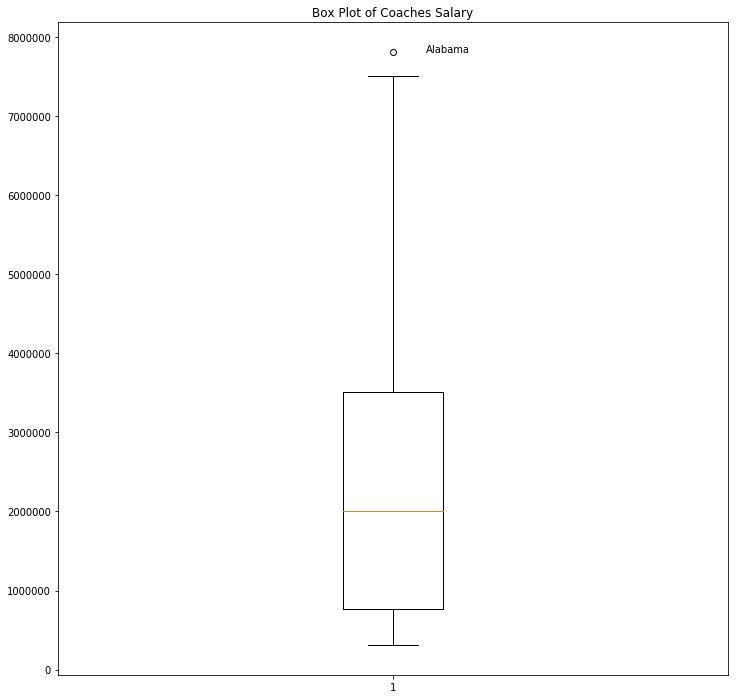

In [10]:
#Options for All coaches boxplot
plt.rcParams["figure.figsize"] = (12, 12)
plt.title("Box Plot of Coaches Salary")
plt.ylab = "Salary"

#Boxplot for all coaches and their salaries
coaches_plot = plt.boxplot(x = "salary", data = data)
#Gets the salary of the outlier
outlier = coaches_plot["fliers"][0].get_data()[1]

#Finds the school with teh outlier salary
teams = data.loc[data["salary"] == outlier[0], "School"].values
#Plots the name of all teams that are outliers in the plot
for team in teams:
    plt.text(y= outlier, x = 1.05, s=team)
#show plot
plt.show()

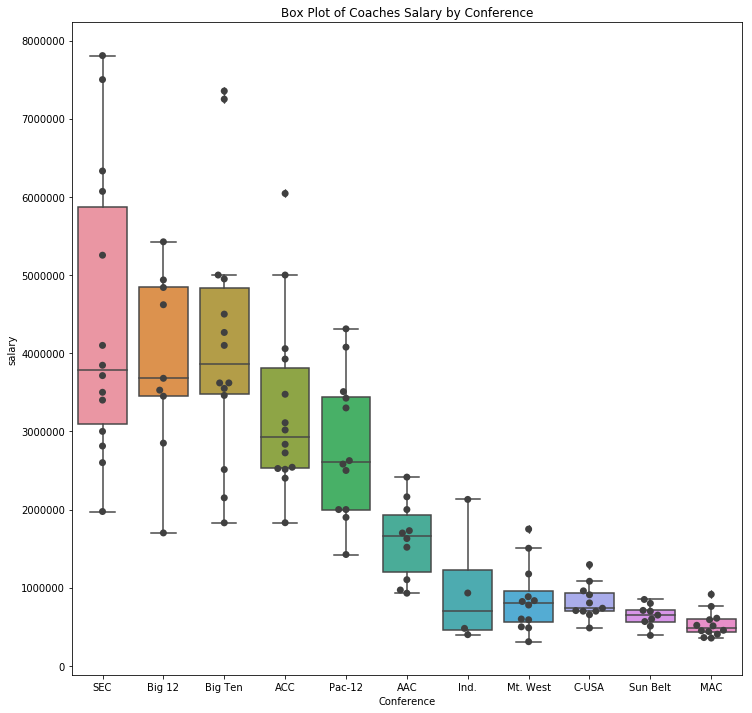

In [11]:
#Options for All coaches boxplot by conference
plt.title("Box Plot of Coaches Salary by Conference")
plt.ylab = "Salary"

#Box plot of coaches by school, ordered
coaches_plot = sns.boxplot(x = "Conference", y = "salary", data = data, order = 
        ["SEC","Big 12", "Big Ten", "ACC", "Pac-12", "AAC", "Ind.", "Mt. West",
            "C-USA", "Sun Belt", "MAC"])
#Swarmplot of coaches by school, ordered
coaches_plot = sns.swarmplot(x = "Conference", y = "salary", data = data, order = 
        ["SEC","Big 12", "Big Ten", "ACC", "Pac-12", "AAC", "Ind.", "Mt. West",
            "C-USA", "Sun Belt", "MAC"], color = ".25", size = 7)
#Show the plot
plt.show()

In [12]:
#Group the schools by conference
grouped = data[["salary", "School", "Conference"]].groupby(
    #count the number of schools and find the average salary of the coaches in the conference
    "Conference",as_index = False).agg({"salary":"mean", "School":"count"})
#Rename the columns
grouped = grouped.rename({"salary":"Avg. Salary", "School": "Num. Schools"}, axis = 1)
#Sort by average salary
grouped.sort_values("Avg. Salary", ascending=False)

,Conference,Avg. Salary,Num. Schools
9,SEC,4.422027e+06,14
3,Big Ten,4.154371e+06,14
2,Big 12,3.892311e+06,9
1,ACC,3.285946e+06,14
8,Pac-12,2.804606e+06,12
0,AAC,1.615868e+06,10
5,Ind.,9.854498e+05,4
7,Mt. West,8.533545e+05,12
4,C-USA,8.216772e+05,11
10,Sun Belt,6.418333e+05,9


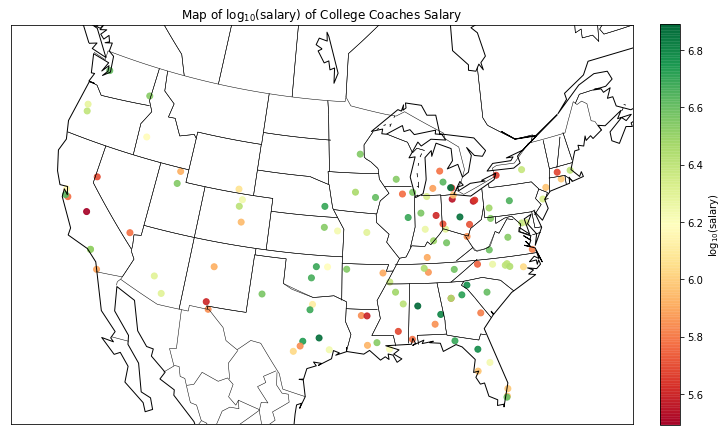

In [13]:
#Making plot larger
plt.rcParams['figure.figsize'] = (12,12)
#Creating map bound on the united states
m = Basemap(projection="aea", lat_1 = 39, lon_0 = -90 , llcrnrlat=19.,urcrnrlat=52,llcrnrlon=-120,urcrnrlon=-60)
m.drawstates()
m.drawcoastlines()
m.drawcountries()
#Get the lat, lng, and salary of all teh schools
lat = data.lat.values
lng = data.lng.values
salary = data.salary.values

#plot the schools on the map using a color map of the log10 of the salary
m.scatter(lng, lat, latlon=True,
          c=np.log10(salary),
          cmap='RdYlGn', alpha = 0.9)

#Add the color bar
plt.colorbar(label=r'$\log_{10}({\rm salary})$', fraction=0.03, pad=0.04)
#set limits
plt.clim(min(np.log10(salary)), max(np.log10(salary)))
#Add title
plt.title("Map of "+ r'$\log_{10}({\rm salary})$' + " of College Coaches Salary")
plt.show()

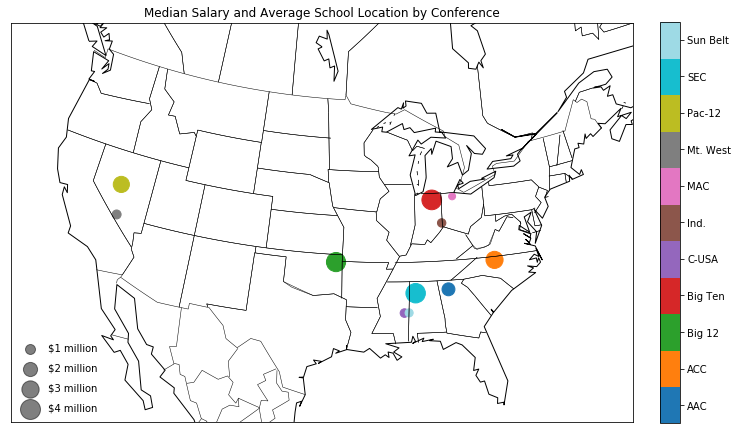

In [14]:
#Grouping the schools by conference and getting the average lat and lng
#And also calculating the median salary
avg_loc = data.groupby("Conference").agg({"salary":"median", 
            "lat":"mean", "lng":"mean"}).reset_index()

#plot options
plt.rcParams['figure.figsize'] = (12,12)
#Create map
m = Basemap(projection="aea", lat_1 = 39, lon_0 = -90 , llcrnrlat=19.,urcrnrlat=52,llcrnrlon=-120,urcrnrlon=-60)
m.drawstates()
m.drawcoastlines()
m.drawcountries()

#Get lat and lng of the conferences
lat = avg_loc.lat.values
lng = avg_loc.lng.values
#create range of numbe rof teams
colors = np.arange(len(lat))
#Get the conference names
conferences = avg_loc.Conference.values
#Get the median salaries
salary = avg_loc.salary.values

#Scatter plot the median salary
m.scatter(lng, lat, latlon=True, c=colors, 
          cmap=plt.cm.get_cmap('tab20', len(conferences)),
         s = salary / 10000)


#Help with the color bar:
#https://gist.github.com/jakevdp/8a992f606899ac24b711
formatter = plt.FuncFormatter(lambda val, loc: conferences[val])

#Creating color bar
plt.colorbar(ticks= [0,1,2,3,4,5,6,7,8,9,10], format=formatter, fraction = 0.03, pad = 0.04)

#Making the labels in the middle of the color
plt.clim(-0.5, 10.5)

#Putting the circles for scale in the bottom left
for a in [1,2,3,4]:
    plt.scatter([], [], c='k', alpha=0.5, s=a * 100,
                label="$" +str(a) + " million")
#putting in legend
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');


#Adding title
plt.title("Median Salary and Average School Location by Conference")
plt.show()

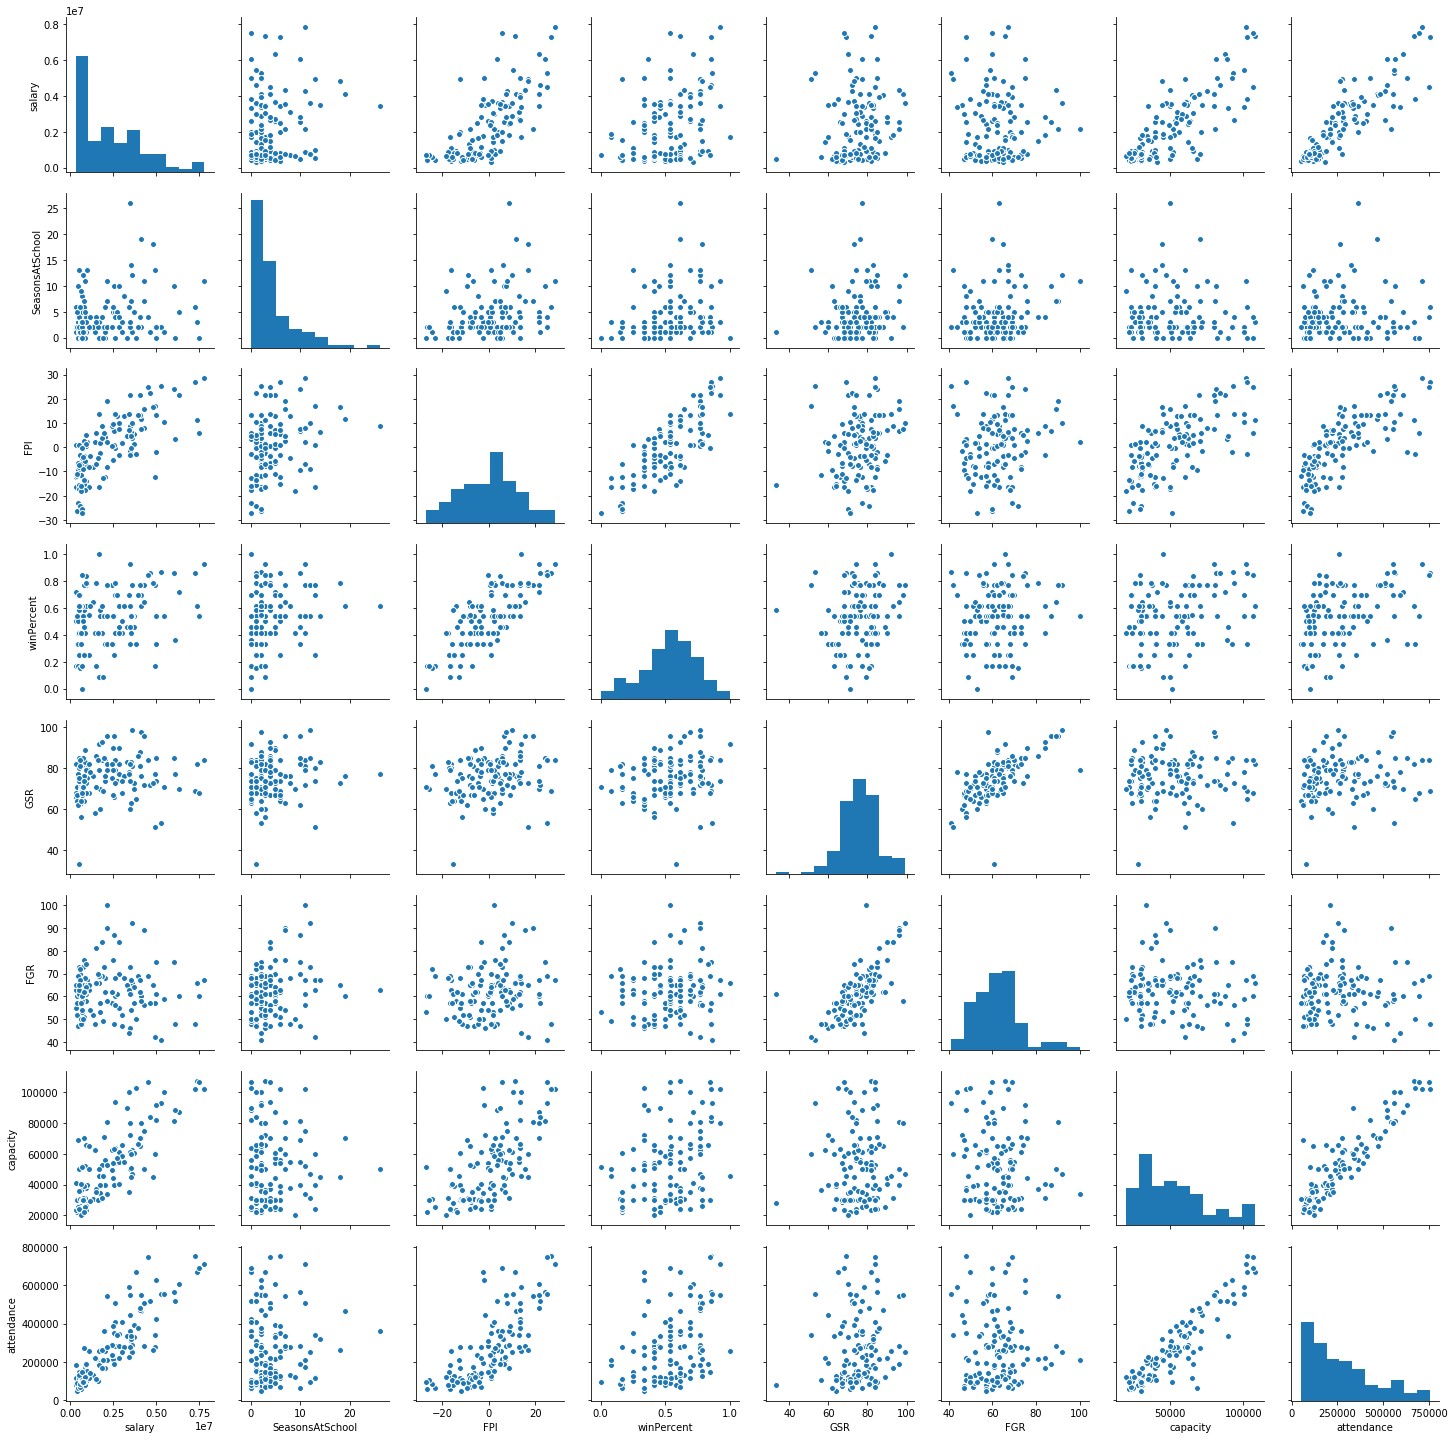

In [15]:
#Pairplot of continous variables
sns.pairplot(data[[ "salary", "SeasonsAtSchool", "FPI", "winPercent", "GSR", "FGR",
                  "capacity", "attendance"]], diag_kind = "hist")

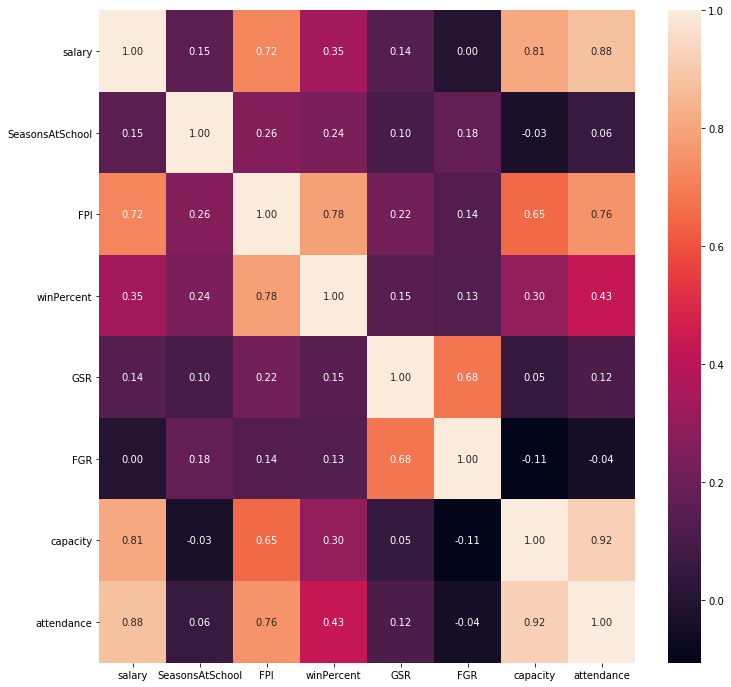

In [16]:
#Creating correlation matrix
corrmat = data[["salary", "SeasonsAtSchool", "FPI", "winPercent", "GSR", "FGR",
                  "capacity", "attendance"]].corr()
#Heatmap from correlation matrix
sns.heatmap(corrmat, annot=True, fmt=".2f")

# Data - Splitting Test and Train

In [17]:
#Evaluation Function to calculate Mean absolute error
def MAE(model, testFrame, actualCol):
    pred = model.predict(testFrame)
    actual = testFrame[actualCol]
    err = pred - actual
    abs_err = np.abs(err)
    return(np.mean(abs_err))

#Setting a random seed
np.random.seed(9999)
#Creating a new column with random numbers
data["rand"] = 0
#Giving the columns a random number
data["rand"] = data["rand"].map(np.random.uniform)
#Splitting the dataset based on the random number
train = data[data.rand >= 0.33]
test = data[data.rand < 0.33]


#Setting up a plot of x = y for diagnostics of test set
x = np.linspace(0,8000000,100)
y = x

### Pooled

In [18]:
#Formula for regression, pooled conferences
simple_linear_regression = "salary ~ FPI + winPercent + confWin + GSR +\
                        capacity + attendance + RK + SeasonsAtSchool"
#Fitting the simple regression
lr_simple = smf.ols(formula=simple_linear_regression, data = train).fit()
#Print the simple regression
print(lr_simple.summary())
#Print the MAE of the test set
print("\nPooled Model Test MAE All Variable: ${:,.2f}".format(MAE(model = lr_simple, actualCol="salary", testFrame=test)))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     36.84
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           2.51e-22
Time:                        08:48:10   Log-Likelihood:                -1199.4
No. Observations:                  80   AIC:                             2417.
Df Residuals:                      71   BIC:                             2438.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.852e+06   1.05e+06     

In [19]:
#Many coefficients are insignificant, adjusting to only have significant coefficients
lr_model_sig = 'salary ~ winPercent + attendance + FPI'
#Fitting OLS with sig variables only
lr_simple_sig = smf.ols(formula=lr_model_sig, data = train).fit()
#Print the regression summary
print(lr_simple_sig.summary())
#MAE on test set
print("\nPooled MAE Significant Variable: ${:,.2f}".format(MAE(model = lr_simple_sig, actualCol="salary", testFrame=test)))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     100.6
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           2.16e-26
Time:                        08:48:10   Log-Likelihood:                -1200.8
No. Observations:                  80   AIC:                             2410.
Df Residuals:                      76   BIC:                             2419.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.712e+06   5.25e+05      3.264      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

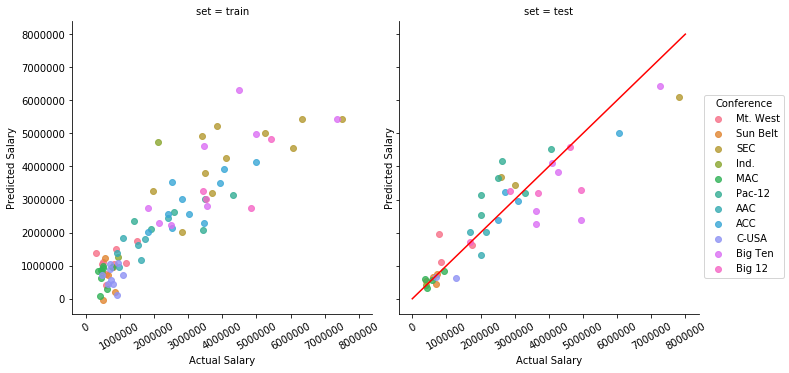

In [20]:
#put new column of test prediction in test set
test["predicted_salary"] = lr_simple_sig.predict(test)
#Create a new column indicating test set
test["set"] = "test"
#Repeat above for train set
train["predicted_salary"] = lr_simple_sig.predict(train)
train["set"] = "train"

#Stack the train and test sets to new df
simple_lr_eval = pd.concat([train, test])
#Plot the actual salary vs predicted salary, color by conference
#Have one plot showing the fit on the train set and another on the test set
ax= sns.lmplot(x = "salary", y = "predicted_salary", col = "set",
                fit_reg = False, data = simple_lr_eval, hue = "Conference")
#Rotate tick labels to be legible
ax.set_xticklabels(rotation=30)
#Add labels
ax.set(xlabel='Actual Salary', ylabel='Predicted Salary')

#Plot the perfec prediction line on the test plot
plt.plot(x,y, c = "red")

plt.show()

### Non-Pooled

In [21]:
#Formula for non-pooled regression, conference as a factor, all variables
lr_nonpooled_f = 'salary ~ FPI + winPercent + confWin + GSR +\
                        capacity + attendance + RK + SeasonsAtSchool + Conference'

#Fitting the formula to the training set
lr_nonpooled_model = smf.ols(formula=lr_nonpooled_f, data = train).fit()

#Print the summary of the regression
print(lr_nonpooled_model.summary())

#MAE on the test set
print("\nAll Variables, Non-Pooled, MAE: ${:,.2f}".format(MAE(lr_nonpooled_model, test, "salary")))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     19.30
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           1.02e-18
Time:                        08:48:11   Log-Likelihood:                -1188.9
No. Observations:                  80   AIC:                             2416.
Df Residuals:                      61   BIC:                             2461.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.64

In [22]:
#Formula for only significant variables, conference as a factor
lr_nonpooled_sig_f = 'salary ~ FPI + attendance + winPercent + Conference'
#Fitting the regression
lr_nonpooled_sig_model = smf.ols(formula=lr_nonpooled_sig_f, data = train).fit()
#Model summary
print(lr_nonpooled_sig_model.summary())
#MAE on test set
print("\nSignificant Variables, Non-Pooled, MAE: ${:,.2f}".format(MAE(lr_nonpooled_sig_model, test, "salary")))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     28.71
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           3.76e-22
Time:                        08:48:11   Log-Likelihood:                -1189.2
No. Observations:                  80   AIC:                             2406.
Df Residuals:                      66   BIC:                             2440.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.00

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


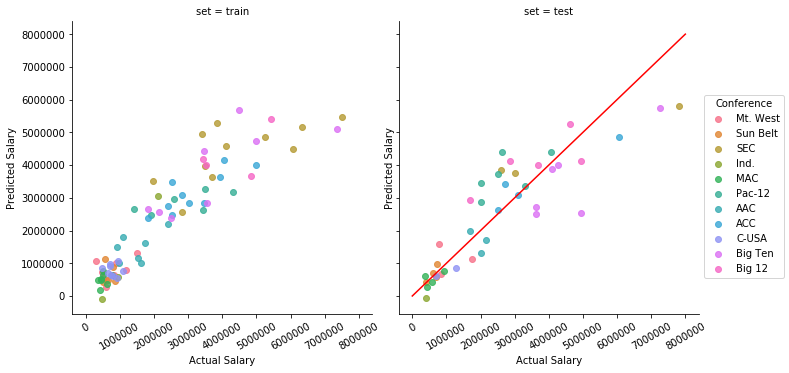

In [23]:
#Adding prediction to the training df
train["nonpooled_predicted_salary"] = lr_nonpooled_sig_model.predict(train)
#Adding prediction to the testing df
test["nonpooled_predicted_salary"] = lr_nonpooled_sig_model.predict(test)

#Stacking the training and the test sets
nonpooled_lr_eval = pd.concat([train, test])

#Making plot larger
plt.rcParams['figure.figsize'] = (12,12)

#Plotting the actual vs. prediction for both test sets
g = sns.lmplot(y = "nonpooled_predicted_salary", x = "salary", 
               data = nonpooled_lr_eval, col="set", hue = "Conference", fit_reg = False)

#Rotating the tick labesl
g.set_xticklabels(rotation=30)
#Adding axis labels
g.set(ylabel='Predicted Salary', xlabel='Actual Salary')

#Plotting perfect prediction
plt.plot(x,y, c = "red")

plt.show()

### Mixed Effect - All Variables

In [24]:
#Formula for the mixed effects regression, all variables
mlm_formula = "salary ~ FPI + winPercent + confWin + GSR + \
                        capacity + attendance + RK + SeasonsAtSchool"
#fitting mixed effects plot to the training data, grouped by conference
mlm = sm.regression.mixed_linear_model.MixedLM.from_formula(formula= mlm_formula,
                groups = train["Conference"], data = train).fit()
#Printing the mixed effects summary
print(mlm.summary())
#MAE on test set
print("\nAll Variables, MLM, MAE: ${:,.2f}".format(MAE(mlm, test, "salary")))

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                     Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      salary           
No. Observations:       80           Method:                  REML             
No. Groups:             11           Scale:                   693976977922.2584
Min. group size:        3            Likelihood:              -1110.3839       
Max. group size:        11           Converged:               No               
Mean group size:        7.3                                                    
-------------------------------------------------------------------------------
                    Coef.       Std.Err.    z    P>|z|    [0.025       0.975]  
-------------------------------------------------------------------------------
Intercept         1847620.893 1276572.716  1.447 0.148  -654415.654 4349657.439
FPI                 67331.798   29868.444  2.254 0.024     8790.724  125872.872
winPercent       -1942803.388  964178.174 -2.015 0.044 -38325

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


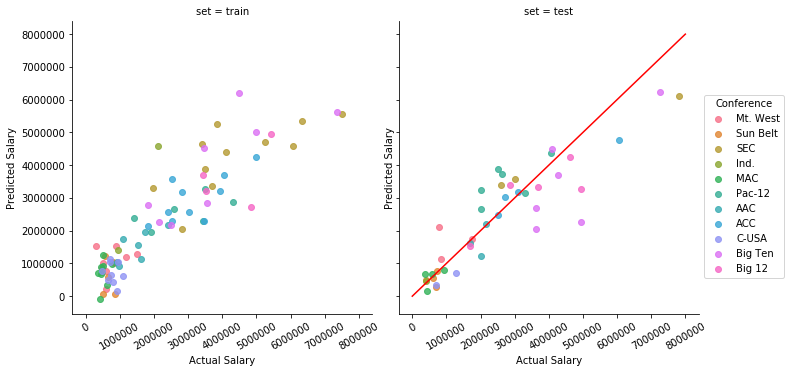

In [25]:
#adding mlm prediction to the train set
train["mlm_pred"] = mlm.predict(train)
#adding mlm prediction to the test set
test["mlm_pred"] = mlm.predict(test)

#combining the test and train set
mlm_lr_eval = pd.concat([train, test])

#Making plot larger
plt.rcParams['figure.figsize'] = (12,12)
#Plotting actual salary vs predicted
g = sns.lmplot(y = "mlm_pred", x = "salary", 
               data = mlm_lr_eval, col="set", hue = "Conference",
              fit_reg = False)
#rotating tick labels
g.set_xticklabels(rotation=30)
#Addig axis labels
g.set(ylabel='Predicted Salary', xlabel='Actual Salary')
#plotting the perfect prediction line in red on test set
plt.plot(x,y, c = "red")

plt.show()

In [26]:
#Formula for mlm with only significant variables
mlm_sig_model = 'salary ~ FPI + attendance + winPercent'
#Fitting the mlm regression line, grouped by conference
mlm_sig = sm.regression.mixed_linear_model.MixedLM.from_formula(
        formula = mlm_sig_model, groups = train["Conference"], data = train).fit()
#Print the mlm summary 
print(mlm_sig.summary())
#Print the MAE on the test set
print("\nSignificant Variables, MLM, MAE: ${:,.2f}".format(
    MAE(mlm_sig, test, "salary")))

                   Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     salary           
No. Observations:     80          Method:                 REML             
No. Groups:           11          Scale:                  637188028057.8727
Min. group size:      3           Likelihood:             -1163.4380       
Max. group size:      11          Converged:              Yes              
Mean group size:      7.3                                                  
---------------------------------------------------------------------------
                Coef.       Std.Err.    z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------
Intercept      1612976.808 602438.163  2.677 0.007   432219.705 2793733.911
FPI              56197.063  23156.700  2.427 0.015    10810.765  101583.361
attendance           6.582      0.850  7.744 0.000        4.916       8.248
winPercent    -2060172.514 9316

# Data - Removing Rows

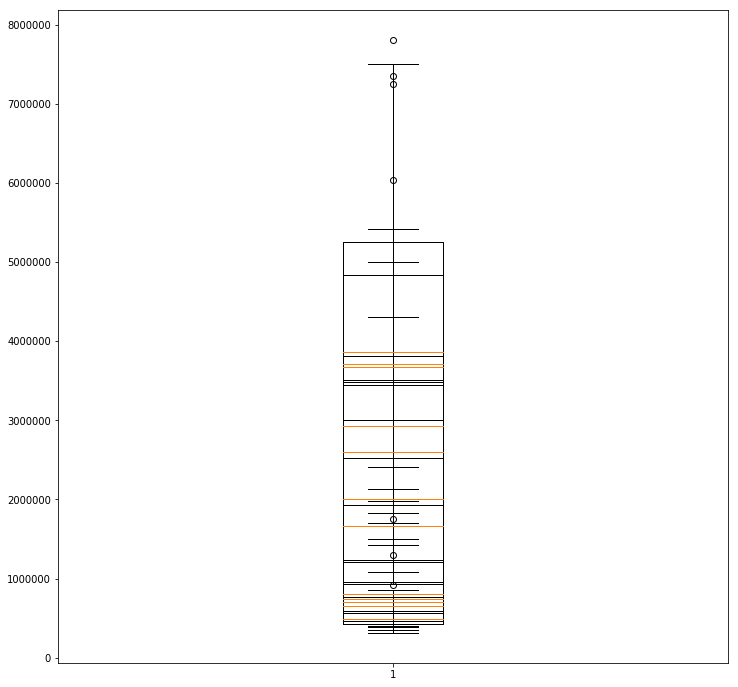

In [27]:
#boxplot of all salaries
box = plt.boxplot(data["salary"])
#Getting the salary of outliers
outlier = box["fliers"][0].get_data()[1]
#Removing teams that have an outlier salary 
data = data.loc[~(data["salary"].isin(outlier)), ]

#Removing Conference Outliers

#Getting a list of the conferences
conferences = list(set(data["Conference"]))
#Loop through each conference
for conf in conferences:
        #boxplot the salaries in the conference
        box = plt.boxplot(data.loc[data.Conference == conf, "salary"])
        #Getting the outlier in the conference
        outlier = box["fliers"][0].get_data()[1]
        #Remove the outliers in the conference from the overall dataset
        data = data.loc[(data["Conference"] != conf)| ~(data["salary"].isin(outlier)), ]

In [28]:
#Count the schools in each conference
conference_count = data.groupby("Conference", as_index=False).\
    aggregate({"School":"count"}).rename({"School":"Count"}, axis = 1)
#Get the conferences that have more than 5 schools remaining
conference_count = conference_count[conference_count.Count > 5]
#Inner merge to have only conferences with five or more schools remaining
data_final = pd.merge(data, conference_count, on = "Conference", how = 'inner')
#Getting the appropriate columns
data_final = data_final[["School", "Conference", "salary", "FPI", "winPercent", "confWin", "GSR", "FGR",
                        "capacity", "attendance", "RK", "SeasonsAtSchool", "rand"]]
#Separating training and test data
train_final = data_final.loc[data_final["rand"] >= 0.33]
test_final = data_final.loc[data_final["rand"] < 0.33]

### Basic LM - Removed Outliers - All Variables

In [29]:
#Formula for simple pooled ols, all variables, outliers removed
lm_cleaned_model = "salary ~ FPI + winPercent + confWin + GSR + \
                        capacity + attendance + RK + SeasonsAtSchool"
#Fit the data with the outliers removed to the formula
lm_cleaned_all = smf.ols(formula=lm_cleaned_model, data=train_final).fit()
#print the regression summary
print(lm_cleaned_all.summary())
#Print the MAE
print("\nAll Variables, Outliers Removed, OLS MAE: ${:,.2f}".format(MAE(lm_cleaned_all, test_final, "salary")))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.41
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           1.97e-22
Time:                        08:48:13   Log-Likelihood:                -1132.6
No. Observations:                  76   AIC:                             2283.
Df Residuals:                      67   BIC:                             2304.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.734e+06      1e+06     

### LM - Removed Outliers - Sig Variables

In [30]:
#Formula with only significant variables
lm_cleaned_model_sig = "salary ~ FPI + attendance + winPercent"
#Fitting the formula to the data with outliers removed
lm_cleaned_sig = smf.ols(formula=lm_cleaned_model_sig, data=train_final).fit()
#Printing the regression summary
print(lm_cleaned_sig.summary())
#Printing the MAE on the test data
print("\nSignificant Variables, Pooled, OLS MAE: ${:,.2f}".format(MAE(lm_cleaned_sig, test_final, "salary")))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     109.3
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           9.77e-27
Time:                        08:48:13   Log-Likelihood:                -1133.6
No. Observations:                  76   AIC:                             2275.
Df Residuals:                      72   BIC:                             2284.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.827e+06   4.91e+05      3.719      0.0

### LM All - Removed Outliers - Nonpooled

In [31]:
#Formula for all variables, conference as a factor
lm_cleaned_model_all = "salary ~ FPI + winPercent + confWin + GSR + \
                        capacity + attendance + RK + SeasonsAtSchool + Conference"
#Fitting the formula to data with the outlier removed
lm_cleaned_all = smf.ols(formula=lm_cleaned_model_all, data=train_final).fit()
#Printing the regression summary
print(lm_cleaned_all.summary())
#Printing the MAE of the model on the test set
print("\nAll Variables, Non-Pooled, Outliers Removed MAE: ${:,.2f}".format(
    MAE(lm_cleaned_all, test_final, "salary")))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     21.78
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           4.20e-19
Time:                        08:48:13   Log-Likelihood:                -1122.8
No. Observations:                  76   AIC:                             2282.
Df Residuals:                      58   BIC:                             2323.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                9.6

### LM SIG - Removed Outliers - CONFERENCE

In [32]:
#Formula with only significant variables, conference as a factor
lm_cleaned_model_conf = "salary ~ attendance + FPI + Conference + winPercent"
#Fitting the model
lm_cleaned_conf = smf.ols(formula=lm_cleaned_model_conf, data=train_final).fit()
#Printing the regression summary
print(lm_cleaned_conf.summary())
#Printing MAE of the model on the test set
print("\nNon-Pooled, Significant Variables, Outlier Removed MAE ${:,.2f}".format(
    MAE(actualCol="salary", testFrame=test_final, model= lm_cleaned_conf)))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     32.66
Date:                Thu, 25 Oct 2018   Prob (F-statistic):           1.77e-22
Time:                        08:48:13   Log-Likelihood:                -1123.6
No. Observations:                  76   AIC:                             2273.
Df Residuals:                      63   BIC:                             2304.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               9.56

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

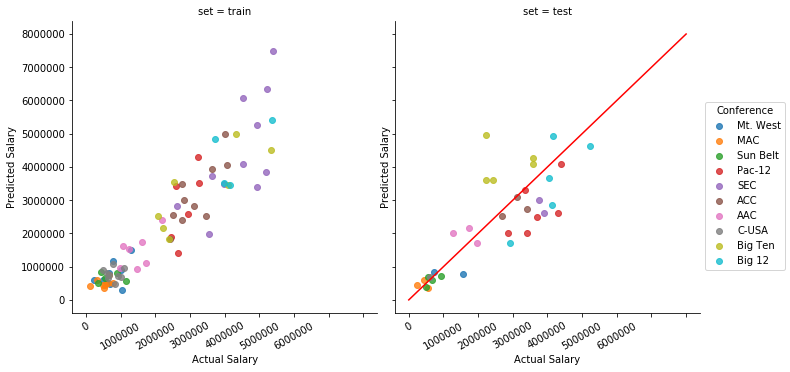

In [33]:
#storing the prediction on train set
train_final["lm_conf_sig_pred"] = lm_cleaned_conf.predict(train_final)
#indicating training set
train_final["set"] = "train"
##Storing prediction on test set in test
test_final["lm_conf_sig_pred"] = lm_cleaned_conf.predict(test_final)
#Indicating test set
test_final["set"] = "test"

#stacking the train and test set
npooled_lr_eval = pd.concat([train_final, test_final])

#making figure larger
plt.rcParams['figure.figsize'] = (12,12)
#plotting actual vs predicted salaries
g = sns.lmplot(x = "lm_conf_sig_pred", y = "salary", 
               data = npooled_lr_eval, col="set", hue = "Conference",
              fit_reg = False)

#Rotating tick labels 30 degrees
g.set_xticklabels(rotation=30)
#Setting axis labels
g.set(ylabel='Predicted Salary', xlabel='Actual Salary')
#Plotting perfect prediction line
plt.plot(x,y, c = "red")

plt.show()

### MLM Cleaned - Removed Outliers - All Variables

In [34]:
#Formula with all variables
mlm_all_formula = "salary ~ FPI + winPercent + confWin + GSR + \
                        capacity + attendance + RK + SeasonsAtSchool"
#Fitting formula to mixed effects plot, grouped bby conference
mlm_final_all = sm.regression.mixed_linear_model.\
MixedLM.from_formula(formula=mlm_all_formula, groups=train_final["Conference"],
                    data = train_final).fit()
#Printing summary of the mixed effects model
print(mlm_final_all.summary())
#Printing the MAE of the mixed effects plot on the test set
print("MLM, All Variables, Outlier Removed MAE: ${:,.2f}".format(
    MAE(actualCol="salary", model=mlm_final_all, testFrame=test_final)))

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       salary           
No. Observations:       76            Method:                   REML             
No. Groups:             10            Scale:                    573663512523.5928
Min. group size:        4             Likelihood:               -1043.8881       
Max. group size:        11            Converged:                No               
Mean group size:        7.6                                                      
---------------------------------------------------------------------------------
                     Coef.        Std.Err.    z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------------
Intercept           1712591.196 1010130.135  1.695 0.090  -267227.488 3692409.880
FPI                   66472.898   19741.432  3.367 0.001    27780.403  105165.392
winPercent         -2039265.271  80888

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


### MLM Cleaned - Removed Outliers - Significant Variables

In [35]:
#Formula with significant variables for MLM
mlm_sig_formula = 'salary ~ attendance + FPI + winPercent'
#Fitting formula to mixed effects model, grouped by conference
mlm_final = sm.regression.mixed_linear_model.\
MixedLM.from_formula(formula=mlm_sig_formula, groups =train_final["Conference"],
                    data = train_final).fit()
#printing summary of the mixed effects model
print(mlm_final.summary())
#Printing MLM MAE on test set
print("MLM, Significant Variables, Outlier Removed MAE: ${:,.2f}".format(
    MAE(actualCol="salary", model=mlm_final, testFrame=test_final)))

                   Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     salary           
No. Observations:     76          Method:                 REML             
No. Groups:           10          Scale:                  524639378840.3182
Min. group size:      4           Likelihood:             -1096.3061       
Max. group size:      11          Converged:              Yes              
Mean group size:      7.6                                                  
---------------------------------------------------------------------------
                Coef.       Std.Err.    z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------
Intercept      1772981.407 532106.608  3.332 0.001   730071.619 2815891.194
attendance           6.221      0.811  7.675 0.000        4.632       7.810
FPI              63426.822  19574.218  3.240 0.001    25062.059  101791.585
winPercent    -2121961.578 7924

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


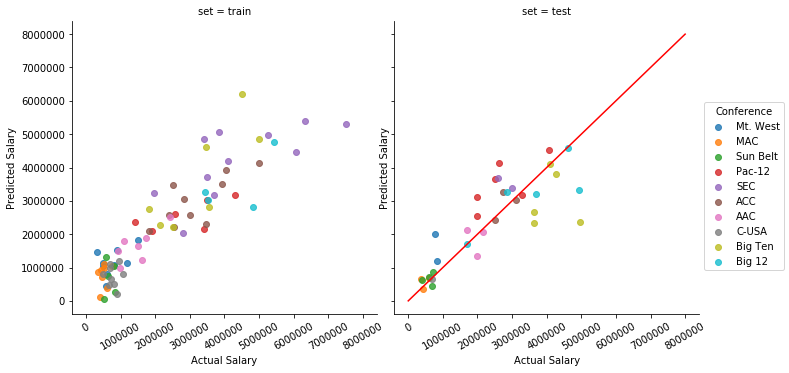

In [36]:
#storing the mlm prediction in the train set  
train_final["mlm_conf_sig_pred"] = mlm_final.predict(train_final)
#storing the mlm prediction of the test set in the test set
test_final["mlm_conf_sig_pred"] = mlm_final.predict(test_final)

#Stacking the training and test sets
mlm_lr_eval = pd.concat([train_final, test_final])

#making the plot size larger
plt.rcParams['figure.figsize'] = (12,12)

#Plotting the actual vs. predicted
g = sns.lmplot(y = "mlm_conf_sig_pred", x = "salary", 
               data = mlm_lr_eval, col="set", hue = "Conference",
              fit_reg = False)

#rotating thetick labels
g.set_xticklabels(rotation=30)
#Setting the axis labels
g.set(ylabel='Predicted Salary', xlabel='Actual Salary')

#Plotting perfect prediction line
plt.plot(x,y, c = "red")

plt.show()

# Modeling Syracuse

In [37]:
#indexing syracuse
syracuse = data.loc[data.School == "Syracuse"]

#Predicting salary for current position
pred_salary = mlm_final.predict(syracuse)
#resetting the index
pred_salary = pred_salary.reset_index()
#printing the suggested vs. actual salary
print("Suggested Salary for Syracuse Head Coach is \
${:,.2f}\nActual Salary ${:,.2f}".format(float(pred_salary[0]), float(syracuse.salary.values[0])))

Suggested Salary for Syracuse Head Coach is $2,587,532.36
Actual Salary $2,401,206.00


# Conference Alterations

In [38]:
#predicting the salary with the non-pooled model in the ACC
acc_salary_pred = lm_cleaned_conf.predict(syracuse)
acc_salary_pred = acc_salary_pred.reset_index()

#Changing the conference to the big 10
syracuse.Conference = "Big Ten"
#predicting the salary with the non-pooled model in the B10
b10_salary_pred = lm_cleaned_conf.predict(syracuse)
b10_salary_pred = b10_salary_pred.reset_index()
#Printing the actual salary, estimated ACC salary, and estimated Big 10 Salaries
print("Actual Salary: ${:,.2f}\nPredicted ACC Salary: ${:,.2f}\nBig Ten Salary: ${:,.2f}"\
     .format(syracuse.salary.values[0], acc_salary_pred[0][0], b10_salary_pred[0][0]))

Actual Salary: $2,401,206.00
Predicted ACC Salary: $2,778,111.11
Big Ten Salary: $2,240,892.76


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [39]:
#Left Merging the data and coaches salary to see which 
#schools are in the coach's df and not in the current df
outliers = pd.merge(coaches, data, how = "left", on = "School")
#Indexing where the win percentafe is missing
outliers = outliers.loc[outliers.winPercent.isna(), "School"]
#Showing the names of the schools
print(outliers)

2                    Alabama
3      Alabama at Birmingham
19                 Charlotte
21                   Clemson
22          Coastal Carolina
24            Colorado State
48                   Liberty
60                  Michigan
75               North Texas
80                Ohio State
107                   Toledo
Name: School, dtype: object


In [40]:
#printing the three coefficients
print("Attendance coefficient:", mlm_final.params["attendance"])
print("FPI coefficient:", mlm_final.params["FPI"])
print("Win Percentage coefficient:", mlm_final.params["winPercent"])

Attendance coefficient: 6.220832926663016
FPI coefficient: 63426.821925378565
Win Percentage coefficient: -2121961.578023044


In [41]:
#creating a new data frame to standardize variables
train_std = train_final[["salary", "FPI", "attendance", "winPercent", "Conference"]]
test_std = test_final[["salary", "FPI", "attendance", "winPercent", "Conference"]]

#Scaler to normalize data
scaler = StandardScaler()
#fitting the scaler
scaler = scaler.fit(train_std[["FPI", "attendance", "winPercent"]])

#Normalizing the continous variables in the training and test set
train_std[["FPI", "attendance", "winPercent"]] = scaler.transform(train_std[["FPI", "attendance", "winPercent"]])
test_std[["FPI", "attendance", "winPercent"]] = scaler.transform(test_std[["FPI", "attendance", "winPercent"]])

#Formula
formula = "salary ~ FPI + attendance + winPercent"
#Fitting model
std_mlm = sm.regression.mixed_linear_model.MixedLM.from_formula(
    formula=formula, groups = "Conference", data = train_std).fit()
#Summary of the model
std_mlm.summary()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                 MixedLM      Dependent Variable:      salary           
No. Observations:      76           Method:                  REML             
No. Groups:            10           Scale:                   524639378840.3181
Min. group size:       4            Likelihood:              -1083.4645       
Max. group size:       11           Converged:               Yes              
Mean group size:       7.6                                                    
------------------------------------------------------------------------------
                    Coef.       Std.Err.    z    P>|z|    [0.025      0.975]  
------------------------------------------------------------------------------
Intercept          2233539.889 108969.702 20.497 0.000 2019963.198 2447116.581
FPI                 709630.825 218999.915  3.240 0.001  280398.878 1138862.771
attendance         1094483.546 142611.106  7.675 0.000  814970.914 1373996.179
winPercent         -407085.436 152018.866 -2.678 0.007 -705036.939 -109133.934
Conference Var 46080166294.090 118432.496                                     
==============================================================================

"""